In [6]:
### Cleaning up data ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/AirQualityUCI.csv', sep=';')

# Create timestamps
df.insert(0, 'Timestamp', pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S'))

# Drop useless columns
df = df.drop(['Unnamed: 15', 'Unnamed: 16', 'Date', 'Time'], axis=1)

# Columns to floats
for col in df.columns.drop('Timestamp'):
    df[col] = df[col].map(lambda x: float(str(x).replace(',', '.')))
    
# Add NaNs instead of 200
df = df.replace(-200, np.nan)

# Remove useless columns at end
df = df.loc[~pd.isnull(df['Timestamp']), :]

# Nice alternative dataframe with timestamps as index
df_ts = df.set_index('Timestamp', drop=True)

df.to_excel('output_data/cleaned.xlsx')

In [7]:
### Imputation ###
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


def impute(df):
    columns = df.columns
    
    # we add back NaN unless we explicitly want imputed values
    add_back_nan = df.isna()

    gts = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'NMHC(GT)']
    add_back_nan.loc[df.index < '2005-01-01', gts] = False
    add_back_nan[['NMHC(GT)']] = False

    # lags = pd.concat([df.shift(i).add_suffix(f'_lag{i}') for i in [1,-1]], axis=1)
    # df = pd.concat([df, lags], axis=1)

    # default bayesian ridge iterative imputer
    model = IterativeImputer(random_state=0,max_iter=1000)
    imputed = pd.DataFrame(model.fit_transform(df), columns=df.columns, index=df.index)[columns]

    # post processing of imputed dataframe
    imputed.drop(filter(lambda x : 'lag_' in x, imputed.columns), axis=1)
    for col in imputed.columns:
        imputed.loc[(imputed[col] < 0.05).to_numpy(), col] = np.nan
    imputed = imputed.interpolate(method='time')

    imputed[add_back_nan] = np.nan

    # save result
    imputed.to_csv('output_data/imputed_all.csv')
    imputed.to_excel('output_data/imputed_all.xlsx')
    
    return imputed

df_ts_imp = impute(df_ts)

In [8]:
import itertools
import holidays
import multiprocessing
from scipy.stats import norm, linregress
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler 
from collections import deque
from sklearn.metrics import root_mean_squared_error

def get_train_test_validation(df_ts, *, target=None, validation=True):
    output_cols = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
    df_ts_input = df_ts.drop(output_cols, axis=1)
    df_ts_output = df_ts[output_cols]
    if target != None:
        df_ts_output = df_ts_output[[target]] 

    if not validation:
        df_train_X = df_ts_input[df_ts.index < '2005-01-01']
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2005-01-01']
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y 
    else:
        df_train_X = df_ts_input[df_ts.index < '2004-11-01']
        df_val_X = df_ts_input[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2004-11-01']
        df_val_y = df_ts_output[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y 
        
class OnlineLinearModel:
    def __init__(self, hours_ahead_prediction, hyperparams, model_hyperparams):
        self.model = None
        self.shift = hours_ahead_prediction
        self.win_size = 25 
        self.scaler = None
        self.hyperparams = hyperparams
        self.model_hyperparams = model_hyperparams
        self.detrend_coefs = None
        
    def _feature_transform(self, train_X : pd.DataFrame, is_live):
        train_X = train_X.copy()

        # interpolation
        if is_live:
            train_X.ffill(inplace=True) 
        else:
            train_X.interpolate(method='time', inplace=True) 
        train_X.dropna(inplace=True) # drop any columns which were NaN right at the start and could not be ffilled
        
        # calculate trends
        # sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)','PT08.S5(O3)']
        # def calc_trend_x():
        #     return (train_X.index - df_ts.index[0]) / pd.Timedelta(hours=1)
        # if not is_live:
        #     self.detrend_coefs = {}
        #     for s in sensors:
        #         self.detrend_coefs[s] = np.polyfit(calc_trend_x(), train_X[s], deg=2)
        # for s in sensors:
        #     train_X[f'{s}_global_detrend'] = train_X[s] - np.polyval(self.detrend_coefs[s], calc_trend_x())
         
        # temporal feature encoding
        train_X = self._derive_temporal_features(train_X)
        
        # non-window features
        train_X = self._derive_concurrent_features(train_X)

        # collapse to window. Keep timestamp of the latest item in the window
        lags = pd.concat([train_X.shift(i).add_suffix(f'_lag{i}') for i in range(1, self.hyperparams['direct_lag_window'] + 1)], axis=1)
        train_X = pd.concat([train_X, lags], axis=1).dropna()
        
        return train_X

    def _normalise(self, X, is_train):
        if is_train:
            self.scaler = MinMaxScaler().fit(X)
        return pd.DataFrame(self.scaler.transform(X), columns=X.columns, index=X.index) 
    
    def _derive_temporal_features(self, train_X):
        train_X = train_X.copy()

        # cyclic encoding
        def cycle_encode(series, max):
            angles = series * (2*np.pi/max)
            return np.sin(angles), np.cos(angles)

        train_X['hour_sin_24h'], train_X['hour_cos_24h'] = cycle_encode(train_X.index.hour, 24)
        train_X['weekday_sin'], train_X['weekday_cos'] = cycle_encode(train_X.index.weekday, 7)
        train_X['month_sin'], train_X['month_cos'] = cycle_encode(train_X.index.month, 12)
        
        # special markers
        train_X['is_weekend'] = train_X.index.weekday >= 5
        train_X['is_rush_hour'] = ((train_X.index.hour >= 6) & (train_X.index.hour <= 10)) | ((train_X.index.hour >= 18) & (train_X.index.hour <= 22)) 

        def days_from_public_hol(date):
            public_holidays = pd.Series(pd.Timestamp(x) for x in holidays.country_holidays('IT', years=[2004, 2005]).keys())
            x = public_holidays - pd.Series([date] * len(public_holidays))
            return x.abs().min().days
        def effect_of_public_hol(date, effect_scale=5):
            # use norm to get a bell shape, normalise it to 1
            return norm.pdf(days_from_public_hol(date), loc=0, scale=effect_scale) / norm.pdf(0, loc=0, scale=effect_scale)

        days_from_hol = train_X.index.map(lambda x : days_from_public_hol(x))
        train_X['days_from_public_hol'] = days_from_hol / days_from_hol.max()
        train_X['effect_of_public_hol'] = train_X.index.map(lambda x : effect_of_public_hol(x))
         
        return train_X

    def _derive_concurrent_features(self, train_X):
        # calculate all the rolls you need
        rolled168 = train_X.rolling(pd.Timedelta('168h'))
        rolled24 = train_X.rolling(pd.Timedelta('24h'))
        rolled12 = train_X.rolling(pd.Timedelta('12h'))
        rolled6 = train_X.rolling(pd.Timedelta('6h'))

        lagged_24h = train_X.rolling(pd.Timedelta('8h'), center=True).mean().shift(24)
        lagged_12h = train_X.rolling(pd.Timedelta('8h'), center=True).mean().shift(12)
        
        train_X, _ = equivalise(train_X, rolled168.mean())

        sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)','PT08.S5(O3)']
        met = ['T', 'AH', 'RH']
        all = sensors + met

        for s in sensors:
            train_X[f'{s}_detrended'] = train_X[s] - rolled168[s].median()
            
            train_X[f'{s}_delta_1h'] = train_X[s] - train_X.shift(1, fill_value=0)[s]
            train_X[f'{s}_delta_3h'] = train_X[s] - train_X.shift(3, fill_value=0)[s]
            train_X[f'{s}_delta_6h'] = train_X[s] - train_X.shift(6, fill_value=0)[s]

        for s in all: 
            train_X[f'{s}_volatility'] = rolled12[s].std()
            train_X[f'{s}_avg_24h'] = lagged_24h[s]
            train_X[f'{s}_avg_12h'] = lagged_12h[s]

        # ratios: ratio between NOx and NO2 reveals freshness of traffic emissions.
        def compress_01(x):
            # compresses a positive value into the 0-1 range with a long tail
            return 1. - np.exp(-np.max([0., x]))
        train_X['nox_no2_ratio'] = (train_X['PT08.S3(NOx)'] / (train_X['PT08.S4(NO2)'] + 1e-6)).map(lambda x: compress_01(x))
        
        # meteorogical interaction effects
        train_X['t_rh_interaction'] = train_X['T'] * train_X['RH'] # humidity-temperature synergies
        
        # capturing momentum via trends
        def get_trend(series):
            return linregress(range(len(series)), series).slope
        for s in all:
            train_X[f'{s}_momentum_6h'] = rolled6[s].apply(get_trend, raw=True)
            train_X[f'{s}_momentum_24h'] = rolled24[s].apply(get_trend, raw=True)
        
        # counter sensor drift
        train_X['sensor_age_days'] = (train_X.index - df_ts.index[0]).days # note we use the original df_ts to get first measurement

        for col in sensors:
            x = np.arange(len(train_X)) 

        
        return train_X
    
    def _y_transform(self, train_y):
        train_y = train_y.interpolate(method='time')
        if self.hyperparams['log_scale_y']:
            series = pd.Series(np.log1p(train_y.to_numpy()).flat, index=train_y.index)
            return series
        else:
            return train_y

    def _y_inverse_transform(self, pred_y):
        if self.hyperparams['log_scale_y']:
            return pd.Series(np.expm1(pred_y.to_numpy()).flat, index=pred_y.index)
        else:
            return pred_y
    
    def train(self, train_X, train_y, transform = False):
        train_X = self._normalise(self._feature_transform(train_X, False) if transform else train_X, is_train=True)
        train_y = self._y_transform(train_y) 
        
        train_X.index = train_X.index + pd.Timedelta(hours=self.shift)
        train_X, train_y = equivalise(train_X, train_y)

        self.model = Ridge(**self.model_hyperparams).fit(train_X.to_numpy(), train_y.to_numpy()) 
        return self
    
    def predict(self, test_X, transform=False):
        test_X = self._normalise(self._feature_transform(test_X, True) if transform else test_X, is_train=False)
        prediction_idx = test_X.index + pd.Timedelta(hours=self.shift)
        predictions = pd.Series(self.model.predict(test_X.to_numpy()).flat, index=prediction_idx)
        return self._y_inverse_transform(predictions)

    def transform(self, X, is_test):
        return self._feature_transform(X, is_live=is_test)

# helper functions
def equivalise(raw_true, raw_predictions):
    predictions = raw_predictions[raw_predictions.index.isin(raw_true.index)]
    true = raw_true[raw_true.index.isin(predictions.index)]
    return true, predictions
    
def grid_search(lag, train_X, train_y, val_X, val_y, hyperparams : dict, model_hyperparams : dict):
    """
    Runs a grid search. The train_y and val_y should NOT be shifted by the desired hours ahead to predict - the model does
    this automatically
    """
    hkeys, hvals = zip(*hyperparams.items())
    mhkeys, mhvals = zip(*model_hyperparams.items())
    hcombos = [x for x in itertools.product(*hvals)]
    mhcombos = [x for x in itertools.product(*mhvals)]

    best_rmse = float('inf')
    best_vals = None
    best_model = None
    
    global test_model # function must be global to run in a pool
    def test_model(hyperparams, model_hyperparams, train_X, train_y, val_X, val_y):
        model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(train_X, train_y, transform=False)
        true, predicted = equivalise(val_y, model.predict(val_X, transform=False))
        rmse = root_mean_squared_error(true.to_numpy(), predicted.to_numpy()) 
        return ((hyperparams, model_hyperparams), rmse)
        
    results = []
    with multiprocessing.Pool() as pool:
        for i, hcombo in enumerate(hcombos):
            hyperparams = {key: val for key, val in zip(hkeys, hcombo)}
            
            model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams={})
            transformed_train = model.transform(train_X, False)
            transformed_val = model.transform(val_X, True)
            for j, mhcombo in enumerate(mhcombos):
                model_hyperparams = {key: val for key, val in zip(mhkeys, mhcombo)}
                results.append(pool.apply_async(test_model, [hyperparams, model_hyperparams, transformed_train, train_y, transformed_val, val_y]) )
    
        for r in results:
            (hyperparams, model_hyperparams), rmse = r.get()
            print(f'Evaluated hyperparameters {hyperparams} and model hyperparameters {model_hyperparams}. RMSE: {rmse}')
            if rmse < best_rmse:
                best_rmse = rmse 
                best_vals = (hyperparams, model_hyperparams)
                best_model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(train_X, train_y, transform=True)
        
        return best_model, best_vals


In [9]:
# Build linear models for all lags and variables

targets = ['CO(GT)', 'C6H6(GT)', 'NO2(GT)', 'NOx(GT)', 'NMHC(GT)']
lags = [1, 6, 12, 24]

hyperparams = {
    'direct_lag_window': [6],#, 24],#, 12, 24, 48, 96],
    'log_scale_y': [True]#, False]
}
model_hyperparams = {
    'alpha': [100]#, 0.2, 0.5, 0.8, 2, 5, 10, 15, 20, 30, 50, 80, 100, 200, 500, 1000]
}

class ModelResult:
    def __init__(self, model, hyperparams, train_y_nona, train_predictions, naive_train_predictions, test_y_nona, test_predictions, naive_test_predictions):
        self.model = model
        self.hyperparams = hyperparams
        
        self.train_y_nona = train_y_nona
        self.train_predictions = train_predictions
        self.naive_train_predictions = naive_train_predictions
        
        self.test_y_nona = test_y_nona
        self.test_predictions = test_predictions
        self.naive_test_predictions = naive_test_predictions

results = {}
for mtarget in targets:
    for mlag in lags:
        print(f'==== Beginning model building for target {mtarget}, lag {mlag} ====')
        df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y = get_train_test_validation(df_ts, target=mtarget, validation=True)
        df_train_X_imp, df_train_y_imp, df_test_X_imp, df_test_y_imp, df_val_X_imp, df_val_y_imp = get_train_test_validation(df_ts_imp, target=mtarget, validation=True)
        
        if mtarget == 'NMHC(GT)':
            df_train_y = df_train_y_imp 
            df_test_y = df_test_y_imp 

        model, vals = grid_search(mlag, df_train_X, df_train_y_imp, df_val_X, df_val_y_imp.dropna(), hyperparams, model_hyperparams)
        
        # train
        df_train_y_nona = df_train_y.dropna()[mtarget]
        df_train_predict_y = model.predict(df_train_X, transform=True)
        naive_train_predictions = df_train_y.shift(mlag).dropna()[mtarget]
        
        df_train_predict_y, naive_train_predictions = equivalise(df_train_predict_y, naive_train_predictions) # make sure we only test values both predict
        df_train_y_nona, df_train_predict_y = equivalise(df_train_y_nona, df_train_predict_y)
        df_train_y_nona, naive_train_predictions = equivalise(df_train_y_nona, naive_train_predictions)

        # test
        df_test_y_nona = df_test_y.dropna()[mtarget]
        df_test_predict_y = model.predict(df_test_X, transform=True)
        naive_test_predictions = df_test_y.shift(mlag).dropna()[mtarget]

        df_test_predict_y, naive_test_predictions = equivalise(df_test_predict_y, naive_test_predictions) # make sure we only test values both predict
        df_test_y_nona, df_test_predict_y = equivalise(df_test_y_nona, df_test_predict_y)
        df_test_y_nona, naive_test_predictions = equivalise(df_test_y_nona, naive_test_predictions)

        results[(mtarget, mlag)] = ModelResult(model, vals, df_train_y_nona, df_train_predict_y, naive_train_predictions, df_test_y_nona, df_test_predict_y, naive_test_predictions)

==== Beginning model building for target CO(GT), lag 1 ====
Evaluated hyperparameters {'direct_lag_window': 6, 'log_scale_y': True} and model hyperparameters {'alpha': 100}. RMSE: 0.9502690137740271
==== Beginning model building for target CO(GT), lag 6 ====
Evaluated hyperparameters {'direct_lag_window': 6, 'log_scale_y': True} and model hyperparameters {'alpha': 100}. RMSE: 1.3157443815083951
==== Beginning model building for target CO(GT), lag 12 ====
Evaluated hyperparameters {'direct_lag_window': 6, 'log_scale_y': True} and model hyperparameters {'alpha': 100}. RMSE: 1.345835277162931
==== Beginning model building for target CO(GT), lag 24 ====
Evaluated hyperparameters {'direct_lag_window': 6, 'log_scale_y': True} and model hyperparameters {'alpha': 100}. RMSE: 1.376161746309893
==== Beginning model building for target C6H6(GT), lag 1 ====
Evaluated hyperparameters {'direct_lag_window': 6, 'log_scale_y': True} and model hyperparameters {'alpha': 100}. RMSE: 4.890641397404299
====

In [12]:
from IPython.display import display 

# Tabular presentation of results

col_idx = pd.MultiIndex.from_product([lags, ['Custom', 'Naive']], names=['Hours Ahead', 'Model'])
row_idx = pd.Index(targets)

train_arr = np.zeros(shape=(len(targets), len(lags)*2))
test_arr = np.zeros(shape=(len(targets), len(lags)*2))
for i, mtarget in enumerate(targets):
    for j, mlag in enumerate(lags):
        res = results[(mtarget, mlag)]
        train_arr[i, j*2] = root_mean_squared_error(res.train_y_nona.to_numpy(), res.train_predictions.to_numpy())
        train_arr[i, j*2 + 1] = root_mean_squared_error(res.train_y_nona.to_numpy(), res.naive_train_predictions.to_numpy())
        test_arr[i, j*2] = root_mean_squared_error(res.test_y_nona.to_numpy(), res.test_predictions.to_numpy())
        test_arr[i, j*2 + 1] = root_mean_squared_error(res.test_y_nona.to_numpy(), res.naive_test_predictions.to_numpy())

df_result_train = pd.DataFrame(train_arr, columns=col_idx, index=row_idx)
df_result_test = pd.DataFrame(test_arr, columns=col_idx, index=row_idx)


col_idx_hyperparams = pd.MultiIndex.from_product([lags, ['lag_window', 'log_transform', 'alpha']], names=['Hours Ahead', 'Hyperparameter'])
hp_arr = np.zeros(shape=(len(targets), len(lags) * 3))
for i, mtarget in enumerate(targets):
    for j, mlag in enumerate(lags):
        res = results[(mtarget, mlag)]
        hp_arr[i, 3*j] = res.hyperparams[0]['direct_lag_window']
        hp_arr[i, 3*j+1] = res.hyperparams[0]['log_scale_y']
        hp_arr[i, 3*j+2] = res.hyperparams[1]['alpha']
df_hyperparams = pd.DataFrame(hp_arr, columns=col_idx_hyperparams, index=row_idx)


display(df_result_train)
display(df_result_test)
display(df_hyperparams)

Hours Ahead         1                       6                       12  \
Model           Custom       Naive      Custom       Naive      Custom   
CO(GT)        0.590005    0.804457    0.787475    1.791707    0.843064   
C6H6(GT)      3.324778    4.346948    4.428772    9.759689    4.917580   
NO2(GT)      19.940397   18.917694   22.341668   47.384371   24.004400   
NOx(GT)      64.256411   63.967439   72.121240  144.350720   78.147454   
NMHC(GT)     91.008054  117.234361  119.021417  237.036538  128.068589   

Hours Ahead                      24              
Model             Naive      Custom       Naive  
CO(GT)         1.689050    0.825969    1.054396  
C6H6(GT)       9.401667    4.817748    5.939453  
NO2(GT)       52.219169   24.271112   30.807473  
NOx(GT)      145.149001   77.756710   93.796558  
NMHC(GT)     225.040118  125.741607  152.323419

Hours Ahead          1                       6                       12  \
Model            Custom       Naive      Custom       Naive      Custom   
CO(GT)         0.927112    0.799386    1.276439    1.812226    1.389601   
C6H6(GT)       5.223131    3.731895    7.427308    8.440132    8.458956   
NO2(GT)       39.818553   25.475014   39.424618   66.754323   39.935237   
NOx(GT)      317.843806  111.838053  397.997017  267.992360  452.603263   
NMHC(GT)     151.058491   87.056316  185.970873  165.115040  206.202422   

Hours Ahead                      24              
Model             Naive      Custom       Naive  
CO(GT)         1.802687    1.806064    1.281914  
C6H6(GT)       8.679765   12.694025    5.984615  
NO2(GT)       68.631317   39.826062   44.412857  
NOx(GT)      269.327489  673.873059  202.487810  
NMHC(GT)     174.535750  278.199323  122.309713

Hours Ahead            1                               6                 \
Hyperparameter lag_window log_transform  alpha lag_window log_transform   
CO(GT)                6.0           1.0  100.0        6.0           1.0   
C6H6(GT)              6.0           1.0  100.0        6.0           1.0   
NO2(GT)               6.0           1.0  100.0        6.0           1.0   
NOx(GT)               6.0           1.0  100.0        6.0           1.0   
NMHC(GT)              6.0           1.0  100.0        6.0           1.0   

Hours Ahead                   12                              24  \
Hyperparameter  alpha lag_window log_transform  alpha lag_window   
CO(GT)          100.0        6.0           1.0  100.0        6.0   
C6H6(GT)        100.0        6.0           1.0  100.0        6.0   
NO2(GT)         100.0        6.0           1.0  100.0        6.0   
NOx(GT)         100.0        6.0           1.0  100.0        6.0   
NMHC(GT)        100.0        6.0           1.0  100.0        6.0   

Hours Ahead                          
Hyperparameter log_transform  alpha  
CO(GT)                   1.0  100.0  
C6H6(GT)                 1.0  100.0  
NO2(GT)                  1.0  100.0  
NOx(GT)                  1.0  100.0  
NMHC(GT)                 1.0  100.0

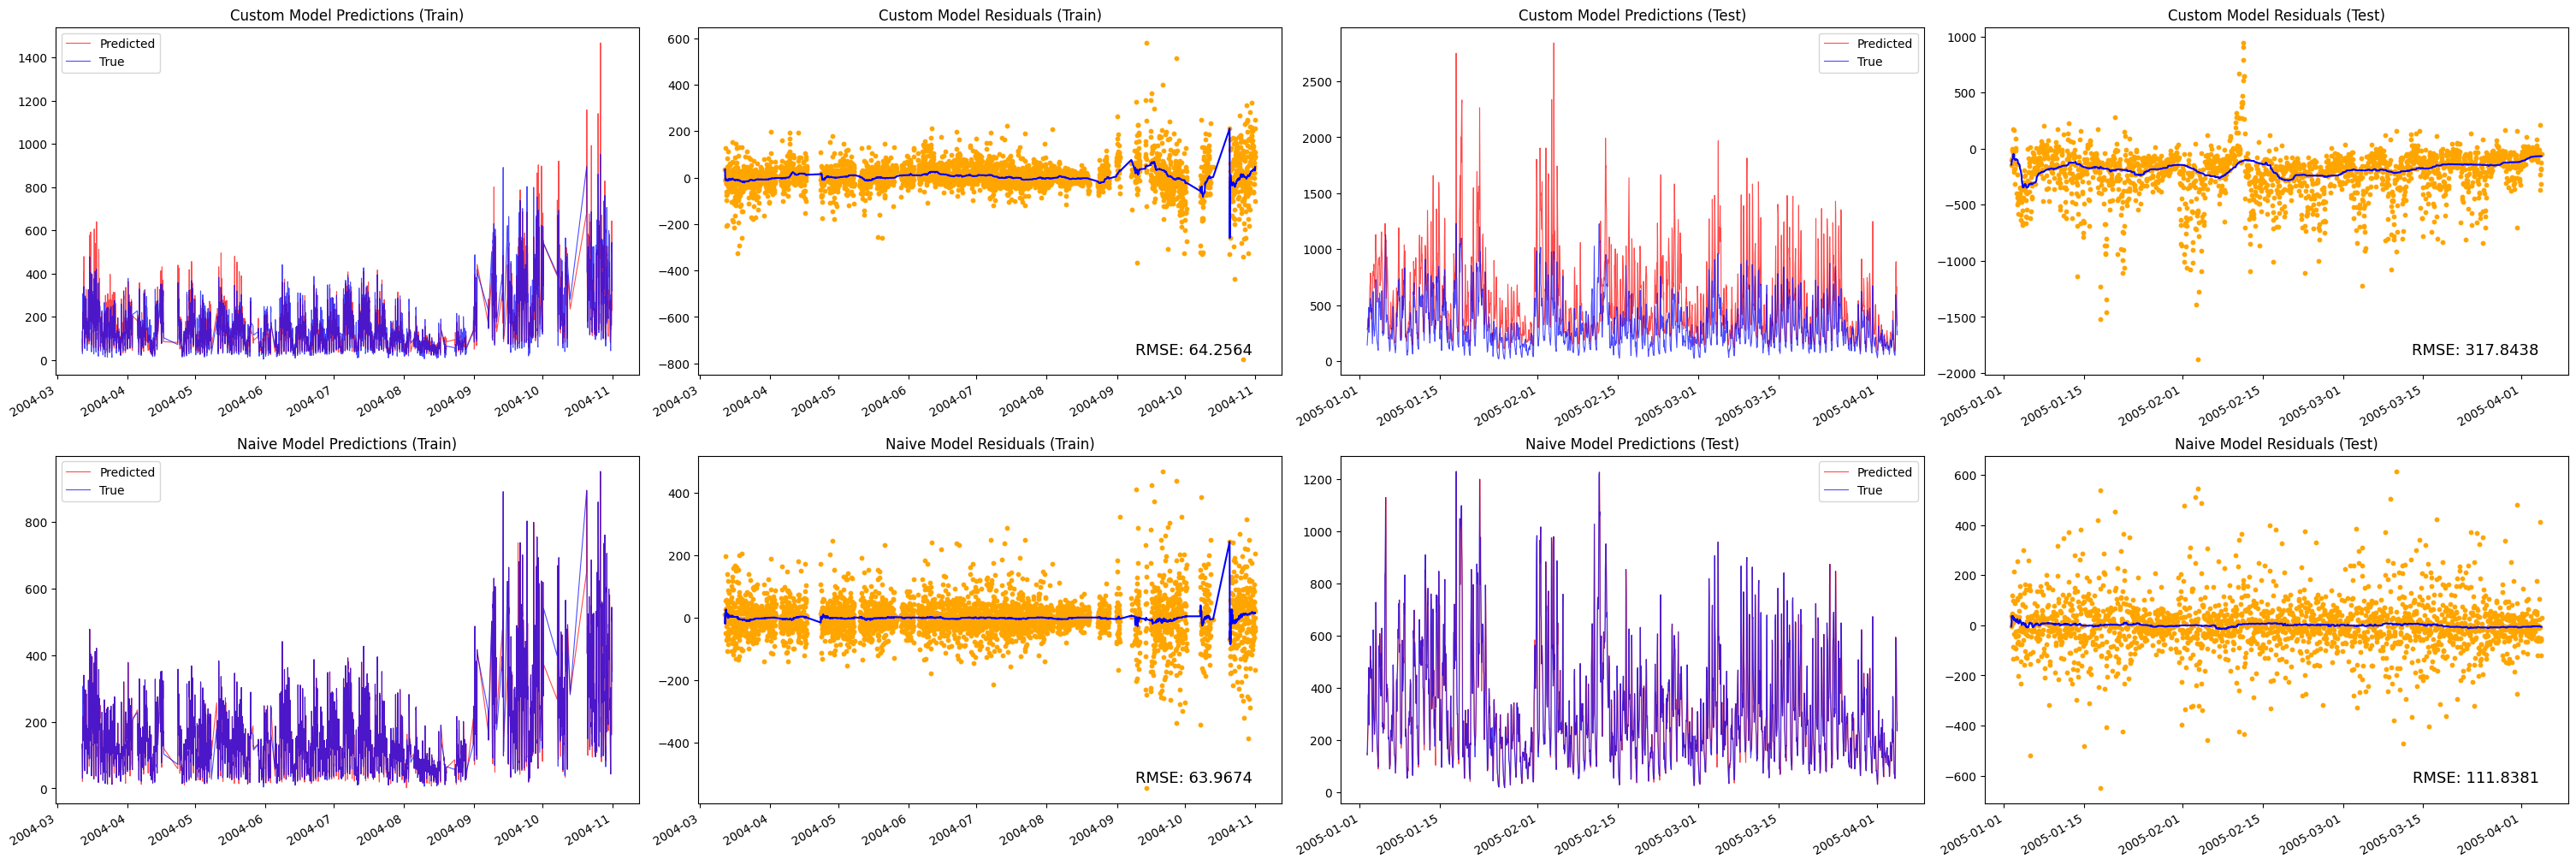

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf 

# Graphs of results
def graph_results(model_result : ModelResult):
    def evaluate_single(true, predictions, title_predictions, title_residuals, ax):
        # prediction plot
        line_pred = predictions.plot(linewidth=0.8, color='red', alpha=0.7, ax=ax[0], label='Predicted')
        line_true = true.plot(linewidth=0.8, color='blue', alpha=0.7, ax=ax[0], label='True')
        ax[0].set_title(title_predictions)
        ax[0].legend()

        for label in ax[0].get_xticklabels():
            label.set_rotation(30)
            label.set_ha('right') 
        ax[0].set_xlabel('')
        
        # residual plot
        residuals = true - predictions
        roll = residuals.rolling('168h').median()

        ax[1].scatter(residuals.index, residuals.values, s=10, color='orange')
        ax[1].set_title(title_residuals)
        ax[1].plot(roll.index, roll.values, color='blue')

        for label in ax[1].get_xticklabels():
            label.set_rotation(30)
            label.set_ha('right') 
        
        ax[1].text(0.95, 0.05, f'RMSE: {root_mean_squared_error(true.to_numpy(), predictions.to_numpy()):.4f}', transform=ax[1].transAxes, ha='right', va='bottom', fontsize='13')
            
    fig, ax = plt.subplots(2, 4, figsize=(30, 10), layout='constrained')

    predict_custom_train = model_result.train_predictions
    predict_naive_train = model_result.naive_train_predictions
    true_train = model_result.train_y_nona

    predict_custom_test = model_result.test_predictions
    predict_naive_test = model_result.naive_test_predictions
    true_test = model_result.test_y_nona

    evaluate_single(true_train, predict_custom_train, 'Custom Model Predictions (Train)', 'Custom Model Residuals (Train)', ax=ax[0, 0:2])
    evaluate_single(true_test, predict_custom_test, 'Custom Model Predictions (Test)', 'Custom Model Residuals (Test)', ax=ax[0, 2:4])
    evaluate_single(true_train, predict_naive_train, 'Naive Model Predictions (Train)', 'Naive Model Residuals (Train)', ax=ax[1, 0:2])
    evaluate_single(true_test, predict_naive_test, 'Naive Model Predictions (Test)', 'Naive Model Residuals (Test)', ax=ax[1, 2:4])

graph_results(results[('NOx(GT)', 1)])